In [1]:
!pip install -U -q tensorflow-addons

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

# Preparing dataset

In [4]:
import numpy as np

## Loading dataset

In [5]:
train_data = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-imgs.npz')['arr_0']
train_label = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-labels.npz')['arr_0']
test_data = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-test-imgs.npz')['arr_0']

print('train_data shape: {0}'.format(train_data.shape))
print('train_label shape: {0}'.format(train_label.shape))
print('test_data shape: {0}'.format(test_data.shape))

train_data shape: (654, 224, 224, 3)
train_label shape: (654,)
test_data shape: (497, 224, 224, 3)


In [6]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"]
)

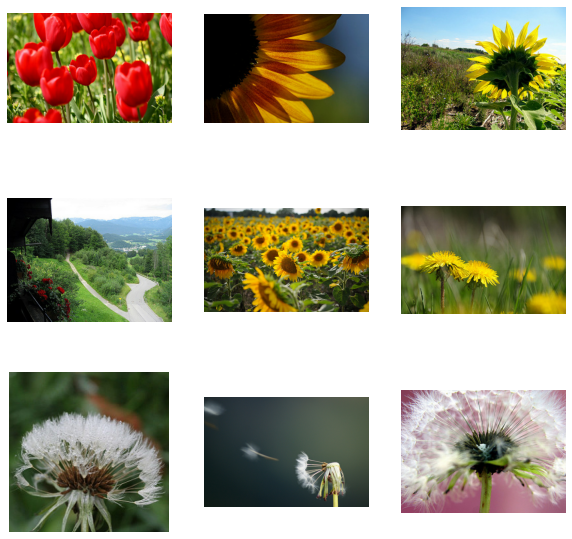

In [7]:
# Visualization
plt.figure(figsize=(10, 10))
for i, image  in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image['image'])
    plt.axis("off")

# Function

## Data Augmentation

In [8]:
# Reference: https://github.com/google-research/simclr/blob/master/data_util.py

@tf.function
def translate(image):
    (h, w) = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.random_flip_left_right(image)

    f = tf.random.uniform([], minval=0, maxval=0.125, dtype=tf.float32)
    (dh, dw) = tf.cast(tf.cast(h, tf.float32)*f, tf.float32), \
        tf.cast(tf.cast(w, tf.float32)*f, tf.float32)
    
    image = tfa.image.translate(image, translations=[dh, dw])
    return image

@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
    sigma = tf.random.uniform((1,))* 1.9 + 0.1

    radius = tf.cast(kernel_size / 2, tf.int32)
    kernel_size = radius * 2 + 1
    x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
    blur_filter = tf.exp(
        -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
    blur_filter /= tf.reduce_sum(blur_filter)
    # One vertical and one horizontal filter.
    blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
    blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
    num_channels = tf.shape(image)[-1]
    blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
    blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
    expand_batch_dim = image.shape.ndims == 3
    if expand_batch_dim:
        image = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(
        image, blur_h, strides=[1, 1, 1, 1], padding=padding)
    blurred = tf.nn.depthwise_conv2d(
        blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
    if expand_batch_dim:
        blurred = tf.squeeze(blurred, axis=0)
    return blurred

@tf.function
def color_jitter(x, s=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def custom_augment(image):
    # image = image['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))

    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    # Random translations
    image = random_apply(translate, image, p=0.5)
    # Randomly apply gausian blur
    image = random_apply(gaussian_blur, image, p=0.5)
    # Randomly apply transformation (color distortions) 
    image = random_apply(color_jitter, image, p=0.8)
    # Randomly apply grayscale
    image = random_apply(color_drop, image, p=0.2)
    
    return image

## Preprocessing

In [9]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

dataset_one = (
    tf.data.Dataset.from_tensor_slices(np.concatenate([train_data, test_data], axis=0))
    .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

dataset_two = (
    tf.data.Dataset.from_tensor_slices(np.concatenate([train_data, test_data], axis=0))
    .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

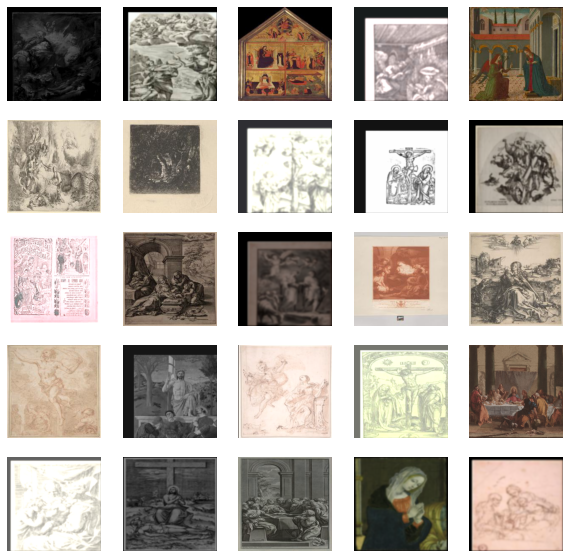

In [10]:
sample_images = next(iter(dataset_one))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(sample_images[n])
    plt.axis('off')
plt.show()

## Creating model

### creating encoder

In [11]:
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

### creating predictor

In [12]:
def get_predictor():
    inputs = tf.keras.layers.Input((2048, ))
    x = tf.keras.layers.Dense(512, activation='relu', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    p = tf.keras.layers.Dense(2048)(x)

    h = tf.keras.Model(inputs, p)

    return h

In [13]:
get_encoder().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
Total params: 31,986,560
Trainable params: 31,929,344
Non-trainable params: 57,216
____________________________________________

In [14]:
get_predictor().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


## Loss function

In [15]:
def loss_func(p, z):
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return - tf.reduce_mean(tf.reduce_sum((p*z), axis=1))

## Train step

In [16]:
@tf.function
def train_step(ds_one, ds_two, f, h, optimizer):
    with tf.GradientTape() as tape:
        z1, z2 = f(ds_one), f(ds_two)
        p1, p2 = h(z1), h(z2)
        loss = loss_func(p1, z2)/2 + loss_func(p2, z1)/2
    
    learnable_params = f.trainable_variables + h.trainable_variables
    gradients = tape.gradient(loss, learnable_params)
    optimizer.apply_gradients(zip(gradients, learnable_params))

    return loss

## Training

In [17]:
def train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for ds_one, ds_two in zip(dataset_one, dataset_two):
            loss = train_step(ds_one, ds_two, f, h, optimizer)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, f, h

# Training

In [18]:
decay_steps = 500
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.01, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

f = get_encoder()
h = get_predictor()

epoch_wise_loss, f, h  = train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=100)

  1%|          | 1/100 [00:22<37:53, 22.96s/it]

epoch: 1 loss: -0.244


 11%|█         | 11/100 [01:48<13:19,  8.98s/it]

epoch: 11 loss: -0.811


 21%|██        | 21/100 [03:13<11:10,  8.49s/it]

epoch: 21 loss: -0.892


 31%|███       | 31/100 [04:37<09:41,  8.43s/it]

epoch: 31 loss: -0.921


 41%|████      | 41/100 [06:02<08:18,  8.45s/it]

epoch: 41 loss: -0.936


 51%|█████     | 51/100 [07:27<06:57,  8.51s/it]

epoch: 51 loss: -0.945


 61%|██████    | 61/100 [08:52<05:32,  8.53s/it]

epoch: 61 loss: -0.951


 71%|███████   | 71/100 [10:20<04:11,  8.66s/it]

epoch: 71 loss: -0.956


 81%|████████  | 81/100 [11:46<02:42,  8.58s/it]

epoch: 81 loss: -0.959


 91%|█████████ | 91/100 [13:11<01:16,  8.47s/it]

epoch: 91 loss: -0.962


100%|██████████| 100/100 [14:29<00:00,  8.70s/it]


# Plotting history

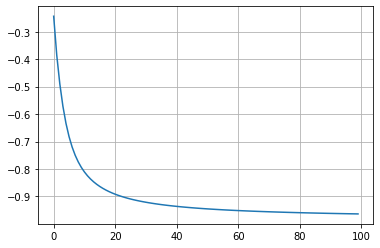

In [19]:
plt.plot(epoch_wise_loss)
plt.grid()
plt.show()

# Saving model

In [20]:
f.save_weights("projection.h5")
h.save_weights("prediction.h5")

# Fine-Tuning

In [31]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

from sklearn.model_selection import train_test_split

train_data = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-imgs.npz')['arr_0']
train_label = np.load('/content/drive/MyDrive/ProbSpace/宗教画テーマの分類/dataset/christ-train-labels.npz')['arr_0']

train_data, val_data, train_label, val_label = train_test_split(train_data, train_label,
                                                                test_size=0.2,
                                                                shuffle=True,
                                                                random_state=2021,
                                                                stratify=train_label)

print('train_data shape: {0}, train_label shape: {1}'.format(train_data.shape, train_label.shape))
print('val_data shape: {0}, val_label shape: {1}'.format(val_data.shape, val_label.shape))

training_ds = (
    tf.data.Dataset.from_tensor_slices((train_data, train_label))
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    tf.data.Dataset.from_tensor_slices((val_data, val_label))
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

train_data shape: (523, 224, 224, 3), train_label shape: (523,)
val_data shape: (131, 224, 224, 3), val_label shape: (131,)


In [32]:
def get_linear_classifier(feature_backbone, trainable=False):
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    feature_backbone.trainable = trainable
    x = feature_backbone(inputs, training=False)
    outputs = tf.keras.layers.Dense(13, activation="softmax", )(x)
    linear_model = tf.keras.Model(inputs, outputs)

    return linear_model

In [33]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

In [34]:
# Create a sub-model for extracting features
projection = get_encoder()
projection.load_weights('projection.h5')

# Create a sub-model for extracting features
rn50 = tf.keras.Model(projection.input, projection.layers[2].output)
rn50.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [35]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=5, verbose=2, 
                                                 restore_best_weights=True)

Epoch 1/100
9/9 [==============================] - 4s 169ms/step - loss: 3.2310 - accuracy: 0.0956 - val_loss: 2.9183 - val_accuracy: 0.0840
Epoch 2/100
9/9 [==============================] - 1s 72ms/step - loss: 2.7932 - accuracy: 0.1778 - val_loss: 2.5750 - val_accuracy: 0.1298
Epoch 3/100
9/9 [==============================] - 1s 72ms/step - loss: 2.6203 - accuracy: 0.1702 - val_loss: 2.4987 - val_accuracy: 0.2290
Epoch 4/100
9/9 [==============================] - 1s 72ms/step - loss: 2.5478 - accuracy: 0.1950 - val_loss: 2.4658 - val_accuracy: 0.2214
Epoch 5/100
9/9 [==============================] - 1s 73ms/step - loss: 2.4615 - accuracy: 0.2027 - val_loss: 2.4340 - val_accuracy: 0.2061
Epoch 6/100
9/9 [==============================] - 1s 72ms/step - loss: 2.4150 - accuracy: 0.2103 - val_loss: 2.3999 - val_accuracy: 0.2214
Epoch 7/100
9/9 [==============================] - 1s 73ms/step - loss: 2.4323 - accuracy: 0.2161 - val_loss: 2.4220 - val_accuracy: 0.2137
Epoch 8/100
9/9 [==

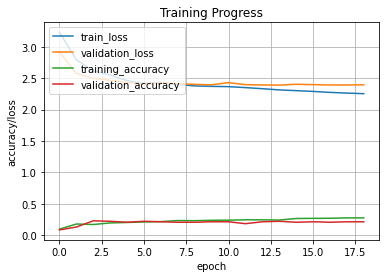

In [36]:
from tensorflow.keras.optimizers import Adam

decay_steps = 500
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.01, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

# Get linear model and compile
tf.keras.backend.clear_session()
model = get_linear_classifier(rn50, True)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")

# Train 
history = model.fit(training_ds,
                    validation_data=validation_ds,
                    epochs=100,
                    callbacks=[early_stopper])

plot_progress(history)

In [37]:
@tf.function
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return image

In [38]:
test_ds = (
    tf.data.Dataset.from_tensor_slices(test_data)
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [39]:
predicted = model.predict(test_ds)

print('predicted shape: {0}'.format(predicted.shape))

predicted shape: (497, 13)


In [40]:
import pandas as pd

predicted = np.argmax(predicted, axis=1)

idx = np.arange(1, 498)

df = pd.concat([pd.DataFrame(idx, columns=['id']), pd.DataFrame(predicted, columns=['y'])], axis=1)

df.to_csv('submission.csv', index=False)

df.head()

,id,y
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2
